# Machine Learning Prediction Model for Stocks


### Overview
---
In this project, an AI model to predict stock prices for the future is created. Stock data from Yahoo Finance is gathered, which is imported into the program using the [yfinance library](https://github.com/ranaroussi/yfinance). Using this data, some helpful indicators are also created with a technique called feature engineering to benefit the prediction capabilities of the model. Professional traders do this as well, using indicators like [SMA](https://www.investopedia.com/terms/s/sma.asp) to aid in their trading and investing strategies. The stock data along with these newly created features are then used to train an AI model, which then makes predictions for future stock prices. 

### The Data
---
To get the data, we first have to import the yfinance library

In [229]:
import yfinance as yf

Then, we decide what ticker we want to get data from and how far back we want to collect data from. In this case we choose AAPL, or Apple's stock ticker and we decide to get the last week's data.

In [230]:
ticker = "AAPL" #ticker to get data from
period = "1w" #d for days, w for weeks, m for months, y for years

Finally we make an API call to yfinance in order to get the history of this ticker.

In [231]:
info = yf.Ticker(ticker) #initializes the ticker with yfinance library
history = info.history(period=period) #data going back to however many years specified by parameter. Returned is a pandas dataframe.
print(history)

                                 Open        High         Low       Close  \
Date                                                                        
2023-02-24 00:00:00-05:00  147.110001  147.190002  145.720001  146.710007   

                             Volume  Dividends  Stock Splits  
Date                                                          
2023-02-24 00:00:00-05:00  55418200          0             0  


For our purposes, we can ignore everything except the *Close* and *Volume* columns as the rest of the columns do not serve to add much in terms of training our model.

To make our code cleaner and easier to access we will put all of the code above into a function called *gethist* to get stock data whenever we need it.

In [232]:
import yfinance as yf
def gethist(ticker, period):
    info = yf.Ticker(ticker) #initializes the ticker with yfinance library
    return info.history(period=period)

### Feature Engineering
---
Feature engineering is a technique where data/computer scientists construct new data from other data to allow machine learning models to make better predictions. For example, we can calculate a 5 day SMA based off the price of the last 5 days. This is a new feature that our model can be trained off of and that provides new information despite being based off of the same original data being fed into model.

For our model, the new features that are engineered are as follows:

1. SMA or Simple Moving Average (10 day, 20 day, and 100 day)
2. TEMA or Triple Exponenetial Moving Average (10 day, 20 day, and 100 day)
3. RSI or Relative Strength Index
4. Rolling High and Rolling Low (10 day)
5. Ratio of S&P500 to Stock Price
6. Ratio of S&P500 RSI to Stock's RSI

To aid us in creating some of these new features we will use a library called [TA-Lib](https://github.com/TA-Lib/ta-lib-python). Specifically TA-Lib will be used to create our SMAs, TEMAs and RSIs. Below is how we use TA-Lib to help us to create these features.

In [233]:
import talib

rawdata = gethist("AAPL", "20y") #get Apple's stock data for the past 20 years using the function we wrote above

price = rawdata["Close"] #each day's stock price can be represented by the close price for that day

sma10 = talib.SMA(price, timeperiod = 10) #SMA for the last 10 days
sma20 = talib.SMA(price, timeperiod = 20) #SMA for the last 20 days
sma100 = talib.SMA(price, timeperiod = 100) #SMA for the last 100 days
tema10 = talib.TEMA(price, timeperiod=10) #TEMA for the last 10 days
tema20 = talib.TEMA(price, timeperiod=20) #TEMA for the last 10 days
tema100 = talib.TEMA(price, timeperiod=100) #TEMA for the last 20 days
rsi10 = talib.RSI(price, timeperiod=10) #RSI for the last 10 days

For the other features we have to create functions specifically for them. They are as follows:

In [234]:
import pandas as pd
import numpy as np

#features that are not included with TALib

def rh(data, timeperiod): #calculate the rolling high
    rollinghighs = data.copy() 
    for i in range(0, timeperiod): #the first couple of days will not have a rolling high as the range of days specificed by the timeperiod parameter would include days not in the data
        rollinghighs[i] = np.NaN
    for i in range(timeperiod, data.size): #go through each day of the data and calculate the max on the last number of days specified by the timeperiod parameter
        rollinghighs[i] = max(data[i-timeperiod:i])
    return rollinghighs
def rl(data, timeperiod): #calculate the rolling low
    rollinglows = data.copy()
    for i in range(0, timeperiod): #the first couple of days will not have a rolling low as the range of days specificed by the timeperiod parameter would include days not in the data
        rollinglows[i] = np.NaN 
    for i in range(timeperiod, data.size): #go through each day of the data and calculate the min on the last number of days specified by the timeperiod parameter
        rollinglows[i] = min(data[i-timeperiod:i])
    return rollinglows
def mktratioprice(data): #calculate ratio of market's price to stock's price
    mkt = gethist("^GSPC", "20y") #^GSPC is the S&P500 index symbol on Yahoo Finance. This allows us to get the market data for the S&P500 companies which are highly infuential to short term price movements
    mktratio = data.copy()
    for i in range(0, data.size):
        mktratio[i] = data[i]/mkt["Close"][i] #for each day in the data, divide the S&P500's price with the stock's price to get a ratio for the model to use
    return mktratio
def mktratioRSI(data, timeperiod): #calculate ratio of market's RSI to stock's RSI
    mkt = gethist("^GSPC", "20y") # ^GSPC is the S&P500 index symbol on Yahoo Finance. This allows us to get the market data for the S&P500 companies which are highly infuential to short term price movements
    mktRSI = talib.RSI(mkt["Close"], timeperiod=timeperiod) #Calculate the S&P500's RSI for the range of days specified by the timeperiod parameter
    mktratio = data.copy()
    for i in range(timeperiod, data.size):
        mktratio[i] = data[i]/mktRSI[i] #for each day in the data, divide the S&P500's RSI with the stock's RSI to get a ratio for the model to use
    return mktratio

To make access to all these new features easier, we will combine them into one function and return a single dataframe.

In [235]:
def getengineeredfeatures(rawdata): #use rawdata to create a single dataframe consisting of all features (this includes raw and engineered features)
    
    price = rawdata["Close"] #price of stock
    volume = rawdata["Volume"] #volume of stock
    
    rh10 = rh(price, timeperiod=10) #rolling high on the last 10 days
    rl10 = rh(price, timeperiod=10) #rolling low on the last 10 days
    
    sma10 = talib.SMA(price, timeperiod = 10) #SMA for the last 10 days
    sma20 = talib.SMA(price, timeperiod = 20) #SMA for the last 20 days
    sma100 = talib.SMA(price, timeperiod = 100) #SMA for the last 100 days
    tema10 = talib.TEMA(price, timeperiod=10) #TEMA for the last 10 days
    tema20 = talib.TEMA(price, timeperiod=20) #TEMA for the last 10 days
    tema100 = talib.TEMA(price, timeperiod=100) #TEMA for the last 20 days
    rsi10 = talib.RSI(price, timeperiod=10) #RSI for the last 10 days
    
    mktratprice = mktratioprice(price) #Ratio between market's price and stock's price
    mktratiorsi10 = mktratioRSI(rsi10, 10) #Ratio between market's RSI and stock's RSI
    
    #Organize all the features and pack them into one dataframe
    d = {'price': price, 'volume': volume, 'sma10': sma10, 'sma20': sma20, 'sma100': sma100, 'tema10': tema10, 'tema20': tema20, 'tema100':tema100, 'rh10':rh10, 'rl10': rl10, 'RSI10':rsi10, 'mktratioprice': mktratprice, 'mktratioRSI10':mktratiorsi10}
    df = pd.DataFrame(data=d)
    
    df = df.dropna() #delete all the rows with no values so there are no errors later on
    
    return df

### Formatting and Preparing the Data
---
Because of the way our model needs to be trained on the data, we have to format it a specific way. To start we want to scale our features to be between 0 and 1 rather than huge number so that our model doesn't have trouble training on the data. We can do this simply with a library called **scikit-learn** sometimes called **sklearn**.

In [236]:
from sklearn.preprocessing import MinMaxScaler

features = getengineeredfeatures(rawdata) #use the rawdata we got from the stock market to make the features with the function we created earlier

scaler = MinMaxScaler() #create a scaler to scale our features between 0 and 1

#scale the data between 0 and 1 which makes the model learn better. Extreme numbers like volume vs RSI will cause weights to be skewed in the model.
scaleddata = pd.DataFrame(scaler.fit_transform(features), columns=features.columns)
print(scaleddata)

         price    volume     sma10     sma20    sma100    tema10    tema20  \
0     0.000083  0.127508  0.000098  0.000079  0.000000  0.000065  0.000081   
1     0.000000  0.129220  0.000069  0.000073  0.000004  0.000022  0.000047   
2     0.000024  0.078627  0.000049  0.000067  0.000009  0.000006  0.000026   
3     0.000030  0.073338  0.000036  0.000057  0.000014  0.000000  0.000010   
4     0.000073  0.060792  0.000027  0.000052  0.000020  0.000018  0.000009   
...        ...       ...       ...       ...       ...       ...       ...   
4734  0.843954  0.007160  0.862745  0.850288  0.846266  0.859752  0.869517   
4735  0.821379  0.007092  0.861036  0.852458  0.846100  0.846439  0.862239   
4736  0.823764  0.004738  0.857919  0.854346  0.846073  0.838483  0.856572   
4737  0.826482  0.003954  0.856624  0.856566  0.846512  0.834473  0.852366   
4738  0.811562  0.006059  0.854399  0.857416  0.847044  0.825159  0.844805   

       tema100      rh10      rl10     RSI10  mktratioprice  mk

Now that we have the scaled data we need to format it so that we can properly train our model. We have to frame our data so that our model is given two parts, the data (training) and the output we want from it (prediction). This will train the model to understand what we want to predict so when it is given new data it can make a good prediction rather than just a random guess.

So, we split the scaled data into these training and prediction parts using the following function:

In [237]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
    data: Sequence of observations as a list or NumPy array.
    n_in: Number of lag observations as input (X).
    n_out: Number of observations as output (y).
    dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
    Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan: 
        agg.dropna(inplace=True)
    return agg

Don't worry if the function above does not make a lot of sense. Just understand that it is splitting the inputed data (defined by the data parameter of the function) into the two parts we talked about above. The parameters *n_in* and *n_out* serve to describe the dimensionality of those two parts. For example if we want our model to take in the last 7 days and predict for the next day, our *n_in* would be 7 and our *n_out* would be 1. If we wanted our model to take in the last 30 days and predict the next 7, our *n_in* would be 30 and our *n_out* would be 7. 

Now we call this function, which returns another pandas dataframe.

In [238]:
preppeddata = series_to_supervised(scaleddata, 7, 1) #train on the last 7 days to predict the next 1 days

The new dataframe is slightly different from the one we created before with the *getengineeredfeatures* function. First the column names are not what we named them, rather they are just var1, var2, etc. They also have the time index next them. var1(t-7) means that the value stored there is variable 1 (or stock price in our case) 7 days before the next day. var2(t-1) is variable 2 (or volume) a day before the next day. 

var1(t) is the price for tommorow which is what we want to predict, but we also have all the other features, like var2, var3, and so on. We don't want to predict these so we will drop them from the dataframe.

In [239]:
preppeddata.drop(preppeddata.columns[range(92, 104)], axis = 1, inplace=True) #drop all the features we don't want to predict
print(preppeddata)

      var1(t-7)  var2(t-7)  var3(t-7)  var4(t-7)  var5(t-7)  var6(t-7)  \
7      0.000083   0.127508   0.000098   0.000079   0.000000   0.000065   
8      0.000000   0.129220   0.000069   0.000073   0.000004   0.000022   
9      0.000024   0.078627   0.000049   0.000067   0.000009   0.000006   
10     0.000030   0.073338   0.000036   0.000057   0.000014   0.000000   
11     0.000073   0.060792   0.000027   0.000052   0.000020   0.000018   
...         ...        ...        ...        ...        ...        ...   
4734   0.839175   0.008666   0.837875   0.814289   0.846031   0.861304   
4735   0.833360   0.006235   0.841781   0.819256   0.846056   0.856603   
4736   0.835412   0.006655   0.844783   0.824351   0.845879   0.853630   
4737   0.851164   0.008090   0.851050   0.829873   0.845727   0.858233   
4738   0.847559   0.007943   0.856219   0.834872   0.845725   0.859139   

      var7(t-7)  var8(t-7)  var9(t-7)  var10(t-7)  ...  var5(t-1)  var6(t-1)  \
7      0.000081   0.000015   0.

Now that we have the data split into the training and prediction parts, we can finally create two seperate dataframes for the two parts. We also have to reshape the input so that we can properly feed it into our model.

In [240]:
vals = preppeddata.values
data_X, data_Y = vals[:, :-1], vals[:, -1] # datax holds the training part and datay holds the prediction part for our model

# reshape input to be 3D [samples, timesteps, features]
data_X = data_X.reshape((data_X.shape[0], 1, data_X.shape[1]))

### The Model Itself
---
*If you don't know what a neural network is, I recommend that you look at this [reference](https://www.investopedia.com/terms/n/neuralnetwork.asp) which looks at neural networks in a financial context.*

The model we use will be a type of recurrent neural network (RNN) called Long Short Term Memory (LSTM). A recurrent neural network is a type of neural network that uses the output from its previous prediction (ie. its prediction for the day before) to influence its next prediction (ie. its prediction for the next day). 

Unfortunately, RNNs have trouble allowing days from futher in the past to influence their predictions for the future. This is where LSTMs come in. The LSTM is a variation of RNNs which allows for datapoints much further back in time to influence the model's predictions, hence the reference to Long Term Memory in the name LSTM. It also allows recent days to still influence its prediction, balancing between allowing data from further back in time as well as data from the more recent past to make its predictions. 

For this reason, an LSTM model is utilized for its prediction capabilities as stock prices are generally related to the stock's past, including anything from yesterday to a couple of months ago.

To atcually code the model, we will use a API called **keras**. This will allow use to utilize LSTMs without having to get into the nitty gritty of coding them from scratch. First, let's import what we need.

In [241]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

With this we can now build the model:

In [242]:
model = Sequential() #initialize the keras AI model
model.add(LSTM(50, input_shape=(data_X.shape[1], data_X.shape[2]), activation="relu")) #create the LSTM layer
model.add(Dense(1)) #this is the number of days we want to predict for. Since we are only predicting for the next day, we say we want the output of the Dense layer to be 1-dimensional

### Training the Model
---

To train the model, let's first split our data into the data we want to train the model on, and then the data we want to test it on. We want to make sure these are different data so the test data we feed the model is different from anything it encountered while training to see if our model can truly predict on new information.

In [243]:
tdpy = 237 # There 237 trading days a year

train_X, train_Y = data_X[:tdpy * 18, :], data_Y[:tdpy * 18] #training data for the model is the last 18 years
test_X, test_Y = data_X[tdpy * 19:tdpy * 20, :], data_Y[tdpy * 19:tdpy * 20] #testing data for the model is the last year

Now we can finally compile and train the model.

In [244]:
model.compile(loss='mae', optimizer='adam')
model.fit(train_X, train_Y, epochs=40, batch_size=72, verbose=2, shuffle=False)

Epoch 1/40
60/60 - 5s - loss: 0.0169 - 5s/epoch - 76ms/step
Epoch 2/40
60/60 - 0s - loss: 0.0398 - 306ms/epoch - 5ms/step
Epoch 3/40
60/60 - 0s - loss: 0.0317 - 303ms/epoch - 5ms/step
Epoch 4/40
60/60 - 0s - loss: 0.0198 - 290ms/epoch - 5ms/step
Epoch 5/40
60/60 - 0s - loss: 0.0120 - 289ms/epoch - 5ms/step
Epoch 6/40
60/60 - 0s - loss: 0.0153 - 290ms/epoch - 5ms/step
Epoch 7/40
60/60 - 0s - loss: 0.0232 - 296ms/epoch - 5ms/step
Epoch 8/40
60/60 - 0s - loss: 0.0070 - 307ms/epoch - 5ms/step
Epoch 9/40
60/60 - 0s - loss: 0.0064 - 305ms/epoch - 5ms/step
Epoch 10/40
60/60 - 0s - loss: 0.0072 - 290ms/epoch - 5ms/step
Epoch 11/40
60/60 - 0s - loss: 0.0119 - 288ms/epoch - 5ms/step
Epoch 12/40
60/60 - 0s - loss: 0.0075 - 301ms/epoch - 5ms/step
Epoch 13/40
60/60 - 0s - loss: 0.0062 - 281ms/epoch - 5ms/step
Epoch 14/40
60/60 - 0s - loss: 0.0076 - 297ms/epoch - 5ms/step
Epoch 15/40
60/60 - 0s - loss: 0.0058 - 296ms/epoch - 5ms/step
Epoch 16/40
60/60 - 0s - loss: 0.0059 - 299ms/epoch - 5ms/step
Epo

The model is now ready to predict stock prices!

### Predicting With the Model
---
All we have to do is call the *predict* function for our model and give it the data we want to predict on. In this case we will use our testing data to see how well our model can predict.

In [245]:
prediction = model.predict(test_X, verbose=0) #tell the model to predict on the testing data

We can plot this prediction versus what atcually happened over the testing data.

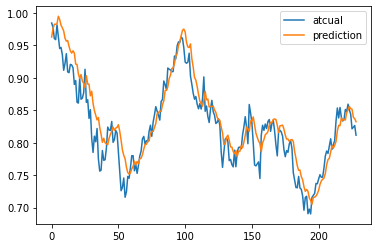

In [246]:
import matplotlib.pyplot as plt

plt.plot(test_Y, label="atcual") #the atcual prices over the testing period
plt.plot(prediction, label="prediction") #the predicted prices that our model generates for the testing period

plt.legend()
plt.show()

Congrats! Now we have a model that can predict the stock prices for Apple!